In [ ]:
# Updating CUDA Toolkit # 
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
# Need to run this command to upgrade matplotlib module because old module does not recognize the 'bar_label' method # 
!pip install matplotlib --upgrade

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.applications.densenet import DenseNet121,preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add ,RepeatVector, Concatenate , Bidirectional , GRU , Add , Flatten 
from tensorflow.keras.optimizers import SGD,Adam,RMSprop 
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from nltk.translate.bleu_score import sentence_bleu
import cv2
import tensorflow as tf
from nltk.tokenize import word_tokenize
import nltk
from sklearn.model_selection import train_test_split
import zipfile
from keras.preprocessing import image 
nltk.download('punkt')
import math
import statistics
import warnings
warnings.filterwarnings("ignore")
from sklearn.utils import resample
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# Loading the drive# 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Downloading the 'DenseNet121' CNN architecture and loading them with 'Chexnet' Weights#
densenet = DenseNet121(weights='/content/drive/MyDrive/Project Data/brucechou1983_CheXNet_Keras_0.3.0_weights.h5',classes = 14,input_shape=(224,224,3))
# Excluding the last layer which is classification # 
CNN1 = Model(inputs=[densenet.input], outputs=[densenet.layers[-2].output])
CNN1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
# Plot of CNN(Densenet 121 with Chexnet weights)
plot_model(CNN1,show_shapes = True)


In [ ]:
# Create a dataframe and load the excel sheet with patient details in the dataframe # 
df4 = pd.read_excel('/content/drive/MyDrive/Project Data/X-ray2.xlsx')
df4.drop(df4.columns[df4.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
# Created a new row in the dataframe to put the xray array features # 
df4['Xray_arrays'] = 'x'

In [ ]:
# Load the images and extracting features by passing it through CNN Network. The extracted features will be loaded into the dataframe #
for i in range(0,len(df4)):
    xray1 = image.load_img(r'/content/drive/MyDrive/Project Data/NLMCXR_png/'+  df4['Image_file1'][i], target_size=(224,224))
    xray1 = image.img_to_array(xray1)
    xray1 = np.expand_dims(xray1, axis=0)
    xray1 = preprocess_input(xray1)
    feat1 = CNN1.predict(xray1, verbose=0)
    xray2 = image.load_img(r'/content/drive/MyDrive/Project Data/NLMCXR_png/'+  df4['Image_file2'][i], target_size=(224,224))
    xray2 = image.img_to_array(xray2)
    xray2 = np.expand_dims(xray2, axis=0)
    xray2 = preprocess_input(xray2)
    feat2 = CNN1.predict(xray2, verbose=0)
    comb = np.concatenate((feat1, feat2), axis=1)
    comb = np.reshape(comb, comb.shape[1])
    df4['Xray_arrays'][i] = np.array(comb)


In [ ]:
# Loading the dataframe into an excel sheet and in pickle format # 
df4.to_excel('/content/drive/MyDrive/Project Data/X-raywithChex.xlsx')
df4.to_pickle('/content/drive/MyDrive/Project Data/X-raywithChex.pkl') 

In [ ]:
# Loading the pickle file containing patient details, report details and image extracted features # 
df5 = pd.read_pickle('/content/drive/MyDrive/Project Data/X-raywithChex.pkl')
df5.drop(df5.columns[df5.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [ ]:
# Preview of the datframe # 
df5

,Patient_ID,Image_file1,Image_file2,Report_ID,Impression,Impression_token,Xray_arrays
0,CXR1,CXR1_1_IM-0001-4001.png,CXR1_1_IM-0001-3001.png,1.xml,normal chest,begin normal chest end,"[0.00048489062, 0.0021194543, 0.0013345798, 0...."
1,CXR2,CXR2_IM-0652-1001.png,CXR2_IM-0652-2001.png,2.xml,no acute pulmonary findings,begin no acute pulmonary findings end,"[0.00020752451, 0.0018519171, 0.0012468158, 0...."
2,CXR3,CXR3_IM-1384-1001.png,CXR3_IM-1384-2001.png,3.xml,no displaced rib fractures pneumothorax or ple...,begin no displaced rib fractures pneumothorax ...,"[0.00041345006, 0.0015575822, 0.0022276195, 0...."
3,CXR4,CXR4_IM-2050-2001.png,CXR4_IM-2050-1001.png,4.xml,bullous emphysema and interstitial fibrosis pr...,begin bullous emphysema and interstitial fibro...,"[6.837919e-05, 0.0010605042, 0.0013954933, 0.0..."
4,CXR5,CXR5_IM-2117-1004003.png,CXR5_IM-2117-1003002.png,5.xml,no acute cardiopulmonary abnormality,begin no acute cardiopulmonary abnormality end,"[9.802635e-05, 0.0015941237, 0.001635213, 0.0,..."
...,...,...,...,...,...,...,...
3815,CXR3995,CXR3995_IM-2046-2001.png,CXR3995_IM-2046-1001.png,3995.xml,interval resolution of bibasilar airspace dise...,begin interval resolution of bibasilar airspac...,"[3.6419344e-05, 0.0011782415, 0.0015695895, 0...."
3816,CXR3996,CXR3996_IM-2047-3001.png,CXR3996_IM-2047-1001.png,3996.xml,clear lungs no acute cardiopulmonary abnormality,begin clear lungs no acute cardiopulmonary abn...,"[5.9841454e-06, 0.0008397544, 0.001182914, 0.0..."
3817,CXR3997,CXR3997_IM-2048-1001.png,CXR3997_IM-2048-1002.png,3997.xml,no acute findings no evidence for active tb,begin no acute findings no evidence for active...,"[0.0004951817, 0.0012138964, 0.0022435354, 1.2..."
3818,CXR3998,CXR3998_IM-2048-1002.png,CXR3998_IM-2048-1001.png,3998.xml,heart size is normal and the lungs are clear,begin heart size is normal and the lungs are c...,"[9.00207e-05, 0.0016318066, 0.0012582872, 0.0,..."


In [ ]:
# Checking the length of the captions percentile-wise. We see that 99 percentile of the total captions have length 55.80~56 
tokens=[]
cap_len = []
for i in range (0,len(df5)):
    temp = (word_tokenize(df5['Impression_token'][i]))
    cap_len.append(len(temp))
    for j in temp:
        tokens.append(j)
cap_len = sorted(cap_len)
x = np.quantile(cap_len, [0,0.25,0.5,0.75,0.80,0.95,0.99,1])
print('The minimum length of a caption is :',min(cap_len))
print('The maximum length of a caption is :',max(cap_len))
print('The 25th percentile length of a caption is :',x[1])
print('The 50th percentile length of a caption is :',x[2])
print('The 75th percentile length of a caption is :',x[3])
print('The 80th percentile length of a caption is :',x[4])
print('The 95th percentile length of a caption is :',x[5])
print('The 99th percentile length of a caption is :',x[6])

The minimum length of a caption is : 3
The maximum length of a caption is : 124
The 25th percentile length of a caption is : 6.0
The 50th percentile length of a caption is : 7.0
The 75th percentile length of a caption is : 13.0
The 80th percentile length of a caption is : 16.0
The 95th percentile length of a caption is : 35.0
The 99th percentile length of a caption is : 55.809999999999945


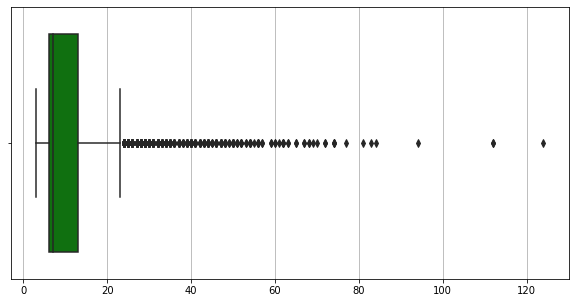

In [ ]:
# Boxplot showing the length of the captions # 
plt.figure(figsize=(10,5))
plt.grid(True)
ax = sns.boxplot(x=cap_len,color='g')

In [ ]:
# Number of captions which have length greater than 56.This means that only 56 captions out of 3820 have length more than 56 # 
sum(i > 56 for i in cap_len)

34

In [ ]:
# Train and Test split # 
train, test = train_test_split(df5, test_size=0.2, random_state=128, shuffle=True)

In [ ]:
# Further bifurcate train and validation set #
train, val = train_test_split(train, test_size=0.125, random_state=128, shuffle=True)

In [ ]:
# Shape of 'train' dataset #
train.shape

(2674, 7)

In [ ]:
# Shape of 'validation' dataset #
val.shape

(382, 7)

In [ ]:
# Shape of 'test' dataset # 
test.shape

(764, 7)

In [ ]:
# Checking the count of various Impressions # 
l= df5['Impression'].value_counts()
l

no acute cardiopulmonary abnormality                                                                                                                                                                                                                                                                                                                                                                                                                                                                     411
no acute cardiopulmonary findings                                                                                                                                                                                                                                                                                                                                                                                                                                                                        181
no acute cardi

In [ ]:
# Creating a new column in the dataframe called Imp_counts. This indicates the number of times an Impression occurs in the dataset #
train['Imp_counts']=1
index_train_list = list(train.index.values)
for index in index_train_list:
    x= l[train['Impression'][index]]
    train['Imp_counts'][index] = int(x)

In [ ]:
# Preview of the train dataframe now #
train

,Patient_ID,Image_file1,Image_file2,Report_ID,Impression,Impression_token,Xray_arrays,Imp_counts
3688,CXR3865,CXR3865_IM-1958-1001.png,CXR3865_IM-1958-1002.png,3865.xml,no acute disease,begin no acute disease end,"[0.00015271554, 0.001685954, 0.0017648058, 0.0...",110
553,CXR572,CXR572_IM-2170-1002.png,CXR572_IM-2170-1001.png,572.xml,no active disease,begin no active disease end,"[6.833039e-05, 0.0014281458, 0.0018368642, 0.0...",132
2064,CXR2161,CXR2161_IM-0779-1001.png,CXR2161_IM-0779-2001.png,2161.xml,borderline heart size otherwise no acute cardi...,begin borderline heart size otherwise no acute...,"[0.00024066206, 0.0015032139, 0.0027480237, 0....",1
840,CXR874,CXR874_IM-2392-2001.png,CXR874_IM-2392-2001.png,874.xml,no acute cardiopulmonary findings,begin no acute cardiopulmonary findings end,"[1.1231606e-05, 0.0012875139, 0.002817747, 0.0...",181
497,CXR514,CXR514_IM-2129-2001.png,CXR514_IM-2129-1001.png,514.xml,no acute cardiopulmonary findings,begin no acute cardiopulmonary findings end,"[0.0004733046, 0.0018225966, 0.0012469604, 0.0...",181
...,...,...,...,...,...,...,...,...
2227,CXR2328,CXR2328_IM-0898-1001.png,CXR2328_IM-0898-2001.png,2328.xml,no acute abnormality,begin no acute abnormality end,"[0.00017444052, 0.0015890027, 0.0009965516, 0....",31
615,CXR637,CXR637_IM-2216-2001.png,CXR637_IM-2216-4001.png,637.xml,no active disease,begin no active disease end,"[0.00021330181, 0.0018213027, 0.0002738267, 0....",132
3297,CXR3460,CXR3460_IM-1681-2001.png,CXR3460_IM-1681-1001.png,3460.xml,no acute cardiopulmonary disease,begin no acute cardiopulmonary disease end,"[3.3749682e-05, 0.0011471047, 0.0015047432, 0....",160
3291,CXR3454,CXR3454_IM-1677-2001.png,CXR3454_IM-1677-3001.png,3454.xml,picc catheter tip mid svc heart size normal lu...,begin picc catheter tip mid svc heart size nor...,"[7.75056e-06, 0.0014538969, 0.0010582898, 0.0,...",1


In [ ]:
# Attempting to rebalance the train dataset since there were many 'Impression' values which were similar thereby creating imbalance #
train1 = train[train['Imp_counts']>=400]
train2 = train[(train['Imp_counts']>=100)&(train['Imp_counts']<400)]
train3 = train[(train['Imp_counts']>=50)&(train['Imp_counts']<100)]
train4 = train[(train['Imp_counts']>=20)&(train['Imp_counts']<50)]
train5 = train[(train['Imp_counts']>=10)&(train['Imp_counts']<20)]
train6 = train[train['Imp_counts']<=10]


train1_down = resample(train1,replace = False,n_samples = train1.shape[0]//17,random_state = 24)
train2_down = resample(train2,replace = False,n_samples = train2.shape[0]//15,random_state = 24)
train3_down = resample(train3,replace = False,n_samples = train3.shape[0]//10,random_state = 24)
train4_down = resample(train4,replace = False,n_samples = train4.shape[0]//15,random_state = 24)
train5_up = resample(train5,replace = True,n_samples = train5.shape[0]*2,random_state = 24)
train6_up = resample(train6,replace = True,n_samples = train6.shape[0]*3,random_state = 24)

add_dfs = [train1_down, train2_down, train3_down, train4_down,train5_up, train6_up]
train =  pd.concat(add_dfs)

In [ ]:
# Shuffling the train dataset
train = shuffle(train)

In [ ]:
# As we see after rebalancing the 'Impression' value_counts has changed completely thereby giving a better balance to the train dataset # 
train['Impression'].value_counts()

no acute intrathoracic abnormality                                                                                                                                                             34
negative for acute cardiopulmonary abnormality                                                                                                                                                 33
no acute preoperative findings                                                                                                                                                                 28
the heart size and cardiomediastinal silhouette are within normal limits pulmonary vasculature appears normal there is no focal air space consolidation no pleural effusion or pneumothorax    27
clear lungs no acute cardiopulmonary abnormality                                                                                                                                               25
                              

In [ ]:
# Tokenizing the 'Captions' of all xray images(start, Unknown and end tokens inclusive)#
docket = Tokenizer(oov_token='UNK')
impression_tokens = []
for i in range(0,len(df5)):
    impression_tokens.append(df5['Impression_token'][i])
docket.fit_on_texts(impression_tokens)


In [ ]:
# Total number of unique words from all captions # 
corpus = len(docket.word_index) + 1

In [ ]:
# Creating seperate lists to store the index values of the test,train and validation datasets.Integrating an iterator to go over each of the lists 
# These iterators will form the building blocks of the generator function #
index_train_list = list(train.index.values) 
train_iterator = iter(index_train_list)
index_val_list = list(val.index.values) 
val_iterator = iter(index_val_list)
index_test_list = list(test.index.values) 
test_iterator = iter(index_test_list)

In [ ]:
# Defining the custom data generator function to release data in batches during training such that the RAM does not crash #  
# This function also converts the text to integer sequences and pads the captions in accordance with maximum lengths decided # 
def batch_generator(data,batch_size,ix_list,docket,iterator,opt_length,corpus):
  while True:      
      lst=[]
      features = []
      x_cap = []
      y_cap = []
      for i in range(0,batch_size):
          try:
              lst.append(next(iterator))
          except StopIteration:
              i = batch_size+1
              break
      if (len(lst)!=0):        
        for index in lst:
          sent = data['Impression_token'][index]
          t2seq = docket.texts_to_sequences([sent])[0]
          for i in range (0,len(t2seq)-1):
              x_sent = t2seq[:i+1]
              y_sent = t2seq[i+1:i+2]
              x_sent= pad_sequences([x_sent], maxlen=opt_length,padding='post' ,truncating='post')[0]
              y_sent = to_categorical([y_sent], num_classes=corpus)[0]
              features.append(data['Xray_arrays'][index])
              x_cap.append(x_sent)
              y_cap.append(y_sent)
        yield [np.array(features), np.array(x_cap)], np.array(y_cap)
      else:
        return 
      
        
     

    

In [ ]:
# Downloading the 'glove 200 dimensional' word embeddings and placing them in a dictionary. All the words in our captions will undergo this embedding #
glove_dict = {}
counter=0
with open('/content/drive/MyDrive/Project Data/Glove Vector files/glove.6B.200d.txt') as file:
    for line in file:
      word = line.split()[0] 
      vector = np.array(line.split()[1:], dtype ='float32')
      glove_dict[word]= vector

In [ ]:
# The total number of words in the created 'glove dictionary'#
print("The number of words with vector embedding we have in the 200-d glove library is :",len(glove_dict))

The number of words with vector embedding we have in the 200-d glove library is : 400000


In [ ]:
# Embedding all the words in the corpus. Every word will now be 200 dimensional vectors #
token_map = docket.word_index
word_dim = 200

glove_matrix = np.zeros((corpus, word_dim)) 
for key, value in token_map.items():
  if key in glove_dict :
    glove_vector = glove_dict[key]
    glove_matrix[value] = glove_vector
  else:
    glove_matrix[value] = np.zeros((1, word_dim))


In [ ]:
# Model creation using Deep Learning 'Tensorflow' building blocks # 
# since 99 percentile of the captions have length around 56 , we have kept the max length of captions to be 56.
opt_length = 56
word_dim = 200
# Encoder
# Image part
img_input = Input(shape=(2048,))
idense1 = Dense(512, activation='relu')(img_input)
idrop1 = Dropout(0.3)(idense1)

# Caption part
cap_input = Input(shape=(opt_length,))
cap_embed = Embedding(corpus, word_dim, mask_zero=True,name = 'embedding')(cap_input)
capdrop1 = Dropout(0.3)(cap_embed)
gru = GRU(512,return_sequences=True, return_state=True)
x,y = gru(capdrop1, initial_state=[idrop1])


# Decoder

blstm = Bidirectional(LSTM(512))(x)
cap_output = Dense(corpus, activation='softmax')(blstm)

In [ ]:
# Defining model inputs and outputs shapes
model7 = Model(inputs=[img_input, cap_input], outputs=cap_output)

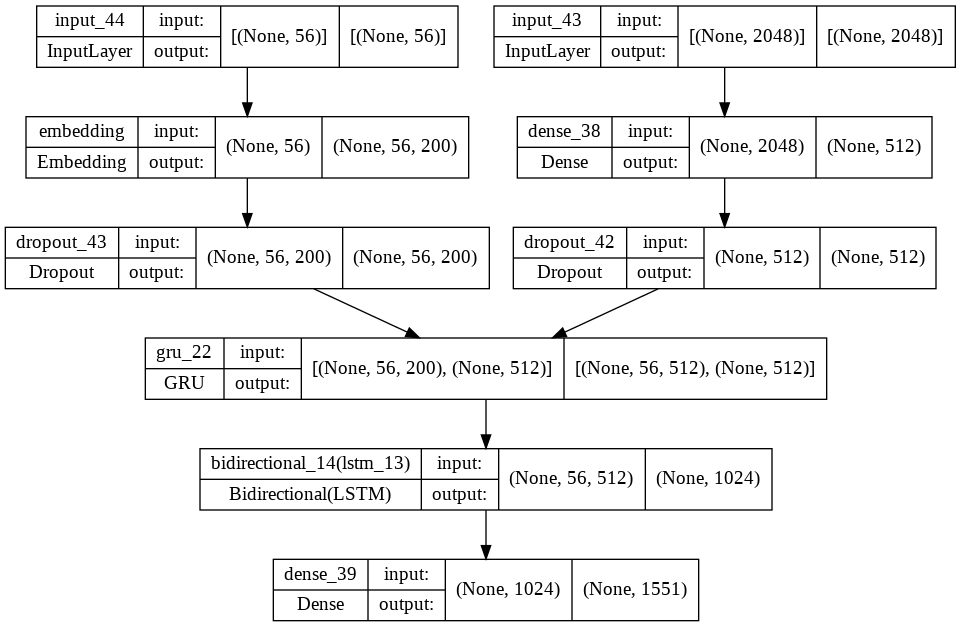

In [ ]:
# Diagram of the model # 
plot_model(model7, show_shapes=True)

In [ ]:
# Summary of the model #
model7.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 56)]         0           []                               
                                                                                                  
 input_43 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 56, 200)      310200      ['input_44[0][0]']               
                                                                                                  
 dense_38 (Dense)               (None, 512)          1049088     ['input_43[0][0]']               
                                                                                           

In [ ]:
# Checking which is the embedding layer in the model # 
model7.layers[2]

In [ ]:
# Making the embedding layer 'non-trainable' since we are already carrying out 'glove' embeddings for the words # 
model7.layers[2].set_weights([glove_matrix])
model7.layers[2].trainable = False

In [ ]:
# Defining a custom function to fit or train the model by imbibing the 'batch_generator' function and looping to train in epochs #
# This function also incorporates the 'Early Stopping' callback in loops # 
def model_training(epochs,train,test,val,opt_length,batch_size,tokenizer,model):
    es_monitor = 3
    best_val = 1000.0000
    counter = 0
    last_val = 0
    for epoch in range(epochs):
      print('Epoch no. {}'.format(epoch + 1))
      index_train_list = list(train.index.values) 
      train_iterator = iter(index_train_list)
      index_val_list = list(val.index.values) 
      val_iterator = iter(index_val_list)
      index_test_list = list(test.index.values) 
      test_iterator = iter(index_test_list)
      train_steps = math.ceil(len(train)/batch_size)
      val_steps = math.ceil(len(val)/batch_size)
      train_generator = batch_generator(df5,batch_size,index_train_list,docket,train_iterator,opt_length,corpus)
      val_generator = batch_generator(df5,batch_size,index_val_list,docket,val_iterator,opt_length,corpus)
      history=model.fit(train_generator, epochs=1,steps_per_epoch = train_steps,verbose=1,validation_data = val_generator, validation_steps =val_steps)
      validation_loss = float(format(history.history['val_loss'][0],".4f"))
      counter+=1
      if validation_loss <= best_val or validation_loss<last_val:
        counter = 0
        best_val = validation_loss
      elif counter == es_monitor and epoch<epochs-1:
        print ("Stopping early at Epoch no. {} as validation loss is increasing".format(epoch+1))
        break
      else:
        last_val = validation_loss

In [ ]:
# Compiling and training the model using the following optimizer and learning rates. 
# The training of the model is done by calling the 'model_training' function # 
opt = RMSprop(learning_rate=10e-5)
model7.compile(loss= 'categorical_crossentropy', optimizer=opt)
model_training(10,train,test,val,56,32,docket,model7)

Epoch no. 1
131/131 [==============================] - 27s 122ms/step - loss: 5.5210 - val_loss: 4.7902
Epoch no. 2
131/131 [==============================] - 13s 99ms/step - loss: 5.0403 - val_loss: 4.4828
Epoch no. 3
131/131 [==============================] - 13s 98ms/step - loss: 4.6795 - val_loss: 4.2451
Epoch no. 4
131/131 [==============================] - 13s 97ms/step - loss: 4.3698 - val_loss: 4.0459
Epoch no. 5
131/131 [==============================] - 13s 97ms/step - loss: 4.0989 - val_loss: 3.9106
Epoch no. 6
131/131 [==============================] - 13s 96ms/step - loss: 3.8622 - val_loss: 3.8174
Epoch no. 7
131/131 [==============================] - 13s 99ms/step - loss: 3.6519 - val_loss: 3.7299
Epoch no. 8
131/131 [==============================] - 13s 97ms/step - loss: 3.4607 - val_loss: 3.6701
Epoch no. 9
131/131 [==============================] - 13s 98ms/step - loss: 3.2881 - val_loss: 3.6168
Epoch no. 10
131/131 [==============================] - 13s 99ms/step - 

In [ ]:
# Compiling and training the model using the following optimizer and learning rates. 
# The training of the model is done by calling the 'model_training' function # 
opt = RMSprop(learning_rate=10e-5)
model7.compile(loss= 'categorical_crossentropy', optimizer=opt)
model_training(5,train,test,val,56,32,docket,model7)

Epoch no. 1
131/131 [==============================] - 26s 121ms/step - loss: 3.0032 - val_loss: 3.5549
Epoch no. 2
131/131 [==============================] - 13s 96ms/step - loss: 2.8475 - val_loss: 3.5361
Epoch no. 3
131/131 [==============================] - 13s 97ms/step - loss: 2.7121 - val_loss: 3.4987
Epoch no. 4
131/131 [==============================] - 13s 96ms/step - loss: 2.5872 - val_loss: 3.4775
Epoch no. 5
131/131 [==============================] - 13s 97ms/step - loss: 2.4675 - val_loss: 3.4859


In [ ]:
# Defining a custom function which takes in 'loss' and 'validation loss' details in a text file and extracts the losses in lists and returns the list#
def losses(path):
  train_loss=[]
  validation_loss=[]
  with open (path, "r",encoding="utf8", errors='ignore') as myfile:
    lines = myfile.readlines()
    for i in range(0, len(lines)):
      if(i % 2 != 0):
          x= lines[i]
          t_loss = x.split('- loss: ')[1].split( ' -')[0]
          train_loss.append(float(t_loss))
          v_loss = x.split('- val_loss: ')[1]
          validation_loss.append(float(v_loss))
    myfile.close()
  return train_loss,validation_loss  

In [ ]:
# Extracting the 'training loss' and 'validation loss' in lists using 'losses' function and loading them in a dataframe alongwith epoch numbers # 
train_loss= losses('/content/drive/MyDrive/Project Data/Model7/Losses7.txt')[0]
validation_loss= losses('/content/drive/MyDrive/Project Data/Model7/Losses7.txt')[1]
epoch = [i for i in range(1,len(train_loss)+1)]
plot_df = pd.DataFrame({"Train_loss":train_loss, "Validation_loss":validation_loss,"Epochs":epoch})

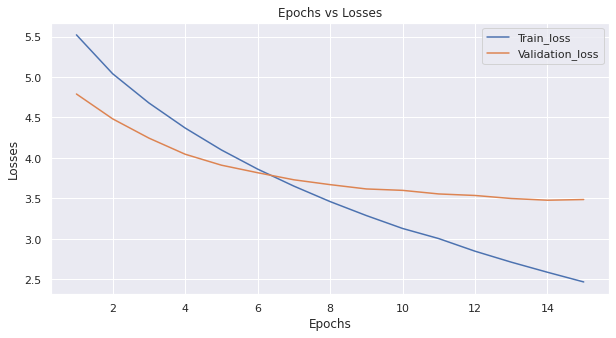

In [ ]:
#  Plotting the 'Epochs vs Losses' curves # 
sns.set(rc = {'figure.figsize':(10,5)})
Train_loss= sns.lineplot(x = "Epochs", y = "Train_loss", data= plot_df)
Validation_loss= sns.lineplot(x = "Epochs", y = "Validation_loss", data= plot_df)
plt.title("Epochs vs Losses")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.gca().legend(('Train_loss','Validation_loss'))
plt.show()

In [ ]:
# Saving the model # 
model7.save('/content/drive/MyDrive/Project Data/Model7/Model7.h5')

In [ ]:
# Loading the model into a variable # 
model7_pred = tf.keras.models.load_model('/content/drive/MyDrive/Project Data/Model7/Model7.h5')

In [ ]:
# Checking the model summary #
model7_pred.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 56)]         0           []                               
                                                                                                  
 input_43 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 56, 200)      310200      ['input_44[0][0]']               
                                                                                                  
 dense_38 (Dense)               (None, 512)          1049088     ['input_43[0][0]']               
                                                                                           

In [ ]:
# Creating a new dataframe to store patient_ids, original captions and predicted captions# 
pred_mod7 = test[["Patient_ID", "Impression"]]
pred_mod7['Predicted_Impression'] = 'x'

In [ ]:
# Defining a custom function to convert integer sequences back to the words # 
def ind2word(pred_ind,word_indexing):
  for key in docket.word_index.keys():    
      if docket.word_index[key]==pred_ind:
          return key
  return

In [ ]:
# Code to carry out predictions by the model, convert them back to words from integer sequences and storing them in dataframes # 
opt_length = 56
build = 'begin'
for index in index_test_list:
  im_test = df5['Xray_arrays'][index]
  im_test = im_test.reshape(1,2048)
  for i in range(opt_length):
      sent_test = docket.texts_to_sequences([build])[0]
      sent_test= pad_sequences([sent_test], maxlen=opt_length,padding='post' ,truncating='post')
      word_pred = model7_pred.predict([im_test,sent_test], verbose=0)
      word_pred = np.argmax(word_pred)
      word_pred = ind2word(word_pred,docket)
      if word_pred == 'end': 
        pred_mod7['Predicted_Impression'][index] = build + ' '+ 'end'
        break
      elif word_pred == None:
        pred_mod7['Predicted_Impression'][index] = build
        break
      build = build + ' ' + word_pred
  pred_mod7['Predicted_Impression'][index] = build    
  build = 'begin'

In [ ]:
# Deleting the start('begin) and end('end') tokens from the predicted captions/Impression section of the report # 
pred_mod7['Predicted_Impression'] = pred_mod7['Predicted_Impression'].str.replace('begin ', '')
pred_mod7['Predicted_Impression'] = pred_mod7['Predicted_Impression'].str.replace('end', '')

In [ ]:
pred_mod7

,Patient_ID,Impression,Predicted_Impression
2570,CXR2688,cardiomegaly with diffuse interstitial opaciti...,stable cardiomegaly with mild cardiomegaly bib...
2047,CXR2144,no acute cardiopulmonary abnormality,no acute cardiopulmonary abnormality
2346,CXR2450,no acute cardiopulmonary abnormality,no acute cardiopulmonary abnormality
1175,CXR1228,three total images heart size is normal tortuo...,no acute cardiopulmonary abnormality
69,CXR71,no acute cardiopulmonary disease,no acute cardiopulmonary abnormality
...,...,...,...
2964,CXR3113,no acute pulmonary disease no evidence for api...,no acute cardiopulmonary abnormality
1288,CXR1348,suspected fractures of the left anterior th an...,no acute cardiopulmonary abnormality
2527,CXR2642,tracheostomy tube in satisfactory position wit...,no acute cardiopulmonary abnormality
620,CXR642,comparison wellexpanded and clear lungs medias...,no acute cardiopulmonary abnormality


In [ ]:
pred_mod7['Predicted_Impression'].value_counts()

no acute cardiopulmonary abnormality                                       730
stable cardiomegaly with mild cardiomegaly bibasilar atelectasis            30
stable cardiomegaly with mild interstitial edema                             2
no acute cardiopulmonary abnormality no evidence of active tuberculosis      2
Name: Predicted_Impression, dtype: int64

In [ ]:
# Storing the dataframe with original and predicted captions in a pickle format#
pred_mod7.to_pickle('/content/drive/MyDrive/Project Data/Model7/GreedyMod7.pkl') 


In [ ]:
# Loading the pickle back into a dataframe to carry out further operations # 
pred_mod7f = pd.read_pickle('/content/drive/MyDrive/Project Data/Model7/GreedyMod7.pkl')

In [ ]:
# Creating a new column 'Bleu_Score' in the dataframe # 
pred_mod7f['Bleu_Score'] = 'x'

In [ ]:
# Defining a function to calculate the 'Bleu Score(1gram)' and storing them in the dataframe # 
# This function also returns the mean of Bleu Scores of 1,2,3 and 4 grams # 
def bleu_scores(df):
  bleu1=[]
  bleu2=[]
  bleu3=[]
  bleu4=[]
  index = df.index
  for i in index:
    df['Bleu_Score'][i] = sentence_bleu([df['Impression'][i].split()],df['Predicted_Impression'][i].split(),weights = (1,0,0,0))
    bleu1.append(sentence_bleu([df['Impression'][i].split()],df['Predicted_Impression'][i].split(),weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([df['Impression'][i].split()],df['Predicted_Impression'][i].split(),weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([df['Impression'][i].split()],df['Predicted_Impression'][i].split(),weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([df['Impression'][i].split()],df['Predicted_Impression'][i].split(),weights = (0.25,0.25,0.25,0.25)))
  return statistics.mean(bleu1),statistics.mean(bleu2),statistics.mean(bleu3),statistics.mean(bleu4)


In [ ]:
# Calling the 'bleu_scores' function # 
bleu_scores(pred_mod7f)

In [ ]:
# Printing out the N-grams Bleu Scores Means for all predictions on 'Test Dataset'
a,b,c,d = bleu_scores(pred_mod7f)
print('Bleu score for 1 gram :',float("{0:.4f}".format(a)))
print('Bleu score for 2 gram :',float("{0:.4f}".format(b)))
print('Bleu score for 3 gram :',float("{0:.4f}".format(c)))
print('Bleu score for 4 gram :',float("{0:.4f}".format(d)))

Bleu score for 1 gram : 0.3633
Bleu score for 2 gram : 0.3093
Bleu score for 3 gram : 0.2343
Bleu score for 4 gram : 0.135


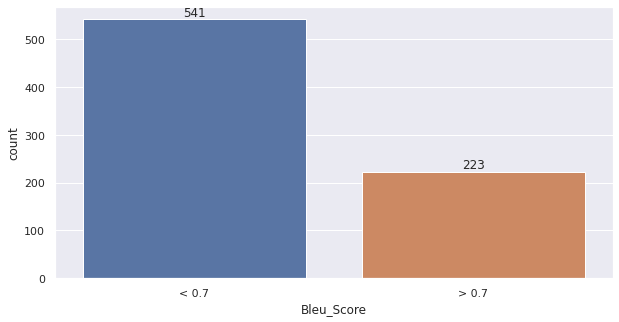

In [ ]:
# Countplot to check the predictions having Bleu scores greater and less than 0.7 # 
# 0.7 is just an assumed benchmark for Bleu scores # 
sns.set(rc = {'figure.figsize':(10,5)})
bplot= sns.countplot(pred_mod7f.Bleu_Score>0.7)
bplot.set(xticklabels=["< 0.7", "> 0.7"])
plt.bar_label(bplot.axes.containers[0], label_type='edge')
plt.show()

In [ ]:
#  Custom function to count the total number of words cumulatively generated by the model # 
def num_of_words(df):
  w_lst = []
  index = df.index
  for i in index:
    temp = df['Predicted_Impression'][i].split(' ')
    for j in temp:
      w_lst.append(j)
  words= list(set(w_lst)) 
  return words

In [ ]:
# Print the words and the number of words generated by the model # 
words = num_of_words(pred_mod7f)
print("The words generated by the model are : ",words)
print("The number of words generated are : ",len(words))

The words generated by the model are :  ['abnormality', 'atelectasis', 'acute', 'cardiopulmonary', 'edema', 'of', 'active', 'no', 'mild', 'cardiomegaly', 'bibasilar', 'with', 'interstitial', 'evidence', 'tuberculosis', 'stable']
The number of words generated are :  16


In [ ]:
# Defining a custom function to review the results #
# This function takes the index as an input and prints out the xray images and the actual and predicted impressions #  
def review_result(index,df):
  xray1 = cv2.imread(os.path.join(r'/content/drive/MyDrive/Project Data/NLMCXR_png', df5['Image_file1'][index]),cv2.IMREAD_UNCHANGED)
  xray2 = cv2.imread(os.path.join(r'/content/drive/MyDrive/Project Data/NLMCXR_png', df5['Image_file2'][index]),cv2.IMREAD_UNCHANGED)
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
  axes[0].imshow(xray1)
  axes[0].grid(None)
  axes[1].imshow(xray2)
  axes[1].grid(None)
  print("Actual Caption : ",df['Impression'][index])
  print("Generated Caption : ",df['Predicted_Impression'][index])
  print("Bleu Score : ",df['Bleu_Score'][index])

In [ ]:
# Storing the current dataframe back to a new pickle # 
pred_mod7f.to_pickle('/content/drive/MyDrive/Project Data/Model7/BleuMod7.pkl')

In [3]:
# Convert and store the final pickle file to excel file(result file) # 
with open("/content/drive/MyDrive/Project Data/Model7/BleuMod7.pkl", "rb") as f:
    final = pickle.load(f)
    
df6 = pd.DataFrame(final)
df6.to_excel('/content/drive/MyDrive/Project Data/Model7/BleuMod7.xlsx')

In [ ]:
#pred_mod7f[pred_mod7f['Bleu_Score'] == 1]

In [ ]:
#pred_mod7f[pred_mod7f['Predicted_Impression']=='stable cardiomegaly with mild cardiomegaly bibasilar atelectasis'] 

In [ ]:
# Defining a custom function to review the results #
# This function takes the index as an input and prints out the xray images and the actual and predicted impressions #  
def review_result(index,df):
  xray1 = cv2.imread(os.path.join(r'/content/drive/MyDrive/Project Data/NLMCXR_png', df5['Image_file1'][index]),cv2.IMREAD_UNCHANGED)
  xray2 = cv2.imread(os.path.join(r'/content/drive/MyDrive/Project Data/NLMCXR_png', df5['Image_file2'][index]),cv2.IMREAD_UNCHANGED)
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
  axes[0].imshow(xray1)
  axes[0].grid(None)
  axes[1].imshow(xray2)
  axes[1].grid(None)
  print("Actual Caption : ",df['Impression'][index])
  print("Generated Caption : ",df['Predicted_Impression'][index])
  print("Bleu Score : ",df['Bleu_Score'][index])

Reviewing Results

Actual Caption :  no acute cardiopulmonary abnormality
Generated Caption :  no acute cardiopulmonary abnormality
Bleu Score :  1.0


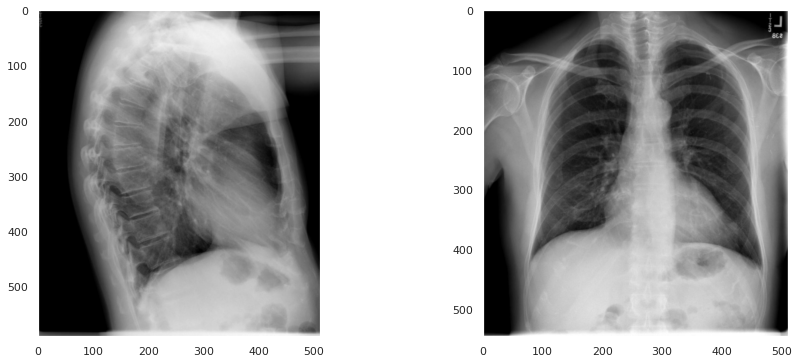

In [ ]:
review_result(80,pred_mod7f)

Actual Caption :  clear lungs no acute cardiopulmonary abnormality
Generated Caption :  no acute cardiopulmonary abnormality
Bleu Score :  0.6065306597126334


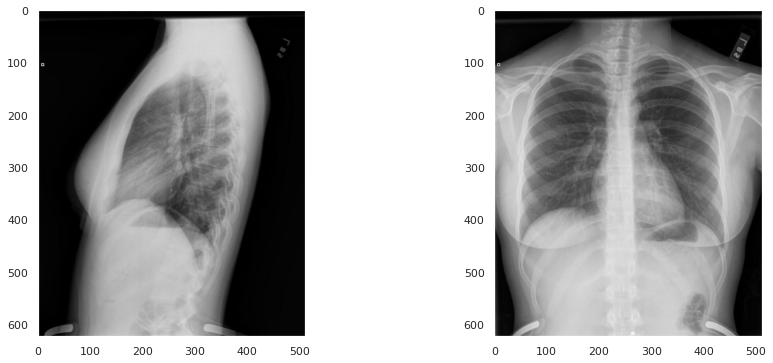

In [ ]:
review_result(3023,pred_mod7f)

Actual Caption :  no acute disease
Generated Caption :  no acute cardiopulmonary abnormality
Bleu Score :  0.5


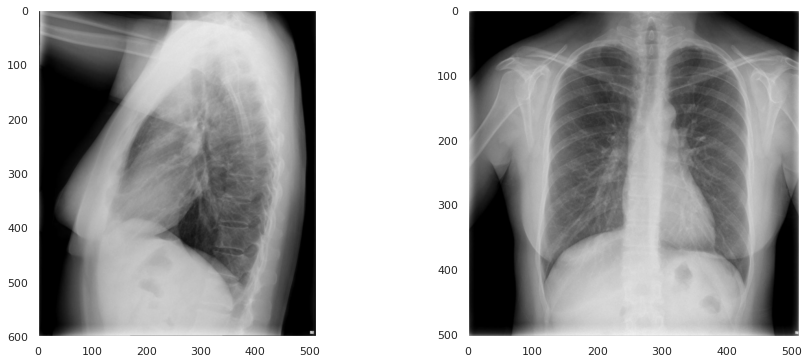

In [ ]:
review_result(2330,pred_mod7f)

Actual Caption :  mild cardiomegaly basilar atelectasis
Generated Caption :  stable cardiomegaly with mild cardiomegaly bibasilar atelectasis
Bleu Score :  0.42857142857142855


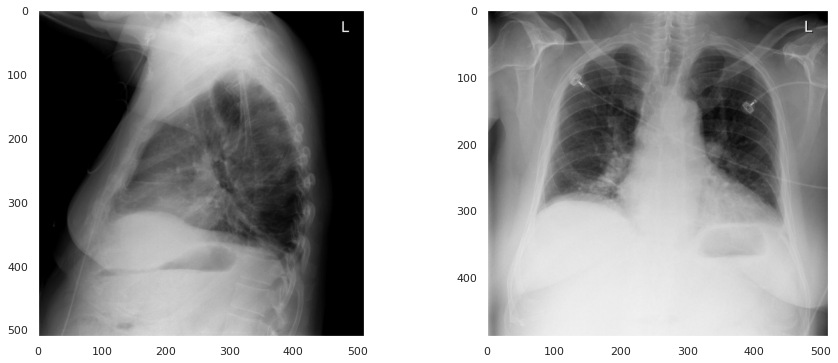

In [ ]:
review_result(2708,pred_mod7f)

Actual Caption :  cardiomegaly without pulmonary edema right medial basilar airspace disease left lower lobe subsegmental atelectasis
Generated Caption :  stable cardiomegaly with mild cardiomegaly bibasilar atelectasis
Bleu Score :  0.10510841176326924


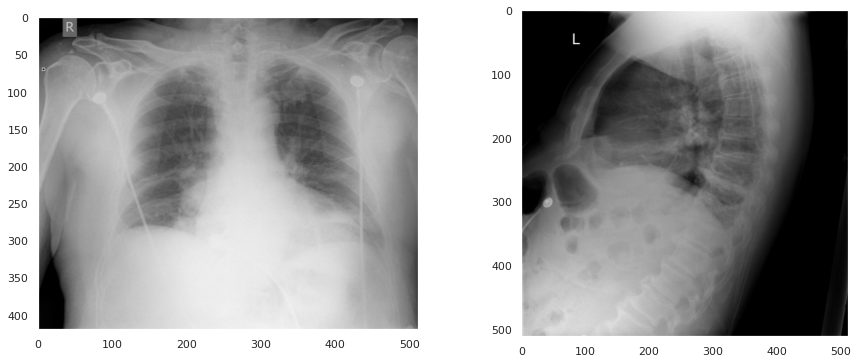

In [ ]:
review_result(3370,pred_mod7f)

Actual Caption :  left upper lobe opacities cannot exclude mass lesions recommend ct chest for further evaluation
Generated Caption :  no acute cardiopulmonary abnormality no evidence of active tuberculosis
Bleu Score :  0


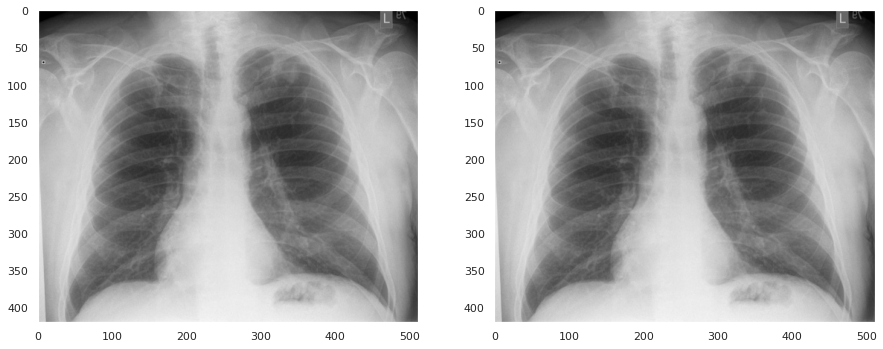

In [ ]:
review_result(2488,pred_mod7f)